# Hierarchical Graph  

A hierarchical graph to find information and write an article with their content.  
In particular, this use case will be focused on a specific topic, the 2024 State of the Union.  
The final goal is to retrieve specific information about the speech, implementing them with some internet search.   

Based on: https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb

## Teams' Composition  

**Research Team** --> Web search, RAG  
**Writing Team** --> Article Writer, Notes Writer 

All the work will be supervised by a "Supervisor" node. 

## Importing Libraries

In [1]:
from langgraph.graph import StateGraph, END 
from langchain_community.tools.tavily_search import TavilySearchResults 
from typing import TypedDict, Annotated, Sequence, List
import functools 
import operator 
import os 
from langchain.agents.tools import tool 
from langchain.agents import create_openai_tools_agent, AgentExecutor 
from langchain_core.messages import HumanMessage, BaseMessage 
from langchain_openai.chat_models import ChatOpenAI 
from langchain.prompts import MessagesPlaceholder, ChatPromptTemplate 
from langchain_community.vectorstores.chroma import Chroma 
from langchain_openai.embeddings import OpenAIEmbeddings 
from langchain.text_splitter import RecursiveCharacterTextSplitter 
from langchain_community.document_loaders import TextLoader
from langchain_core.output_parsers import StrOutputParser

from secret_api_key import openaikey 
from tavily import tavilykey 
from langchain_key import langchainkey

os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_ENDPOINT']="https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY']=langchainkey
os.environ['LANGCHAIN_PROJECT']="Hierarchical Graph" 

os.environ['OPENAI_API_KEY'] = openaikey 
os.environ['TAVILY_API_KEY'] = tavilykey 

## Writing Functions  

These functions will be needed for different purposes over the project, such as: creating agents; executing agents; ... 

In [2]:
def create_agent(llm: ChatOpenAI, system_prompt: str, tools: list):
    prompt = ChatPromptTemplate.from_messages([
        ('system', system_prompt),
        MessagesPlaceholder(variable_name='messages'), 
        MessagesPlaceholder(variable_name='agent_scratchpad') 
    ])
    agent = create_openai_tools_agent(
        llm=llm,
        prompt=prompt,
        tools=tools
    )
    agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools) 
    return agent_executor 

def execute_agent(messages: list, agent):
    answer = agent.invoke(messages) 
    return {'messages': [HumanMessage(content=answer['output'])]}   

def create_supervisor(llm: ChatOpenAI, members: list, system_prompt: str):
    options = ['FINISH'] + members 
    prompt = ChatPromptTemplate.from_messages([
        ('system', system_prompt),
        MessagesPlaceholder(variable_name='messages'), 
        ('system', '''Based on the conversation above, who should act next? Or is it enough to finish? Select one of: {options}''')
    ]).partial(options=str(options)) # when using partial it is even possible to add variables not included in the prompt
    return prompt | llm | {'next_node':StrOutputParser()}

def simple_chains(state, chain):
    response = chain.invoke(state).content 
    return {'messages':[HumanMessage(content=response)]}
    

## Vector DB  

This will be used for the RAG process.

In [ ]:
# Creating the vector DB 
splitter = RecursiveCharacterTextSplitter(separators=['\n\n', '\n'], chunk_size=1000, chunk_overlap=10) 
sotu = TextLoader('./sotu.txt', encoding='utf-8').load_and_split(splitter) 
embedding_model = OpenAIEmbeddings() 
vector_db = Chroma.from_documents(documents=sotu, embedding=embedding_model, persist_directory='.') 

In [3]:
# Loading the vector db 
embedding_model = OpenAIEmbeddings() 
vector_db = Chroma(persist_directory='./RAG_LangGraph', embedding_function=embedding_model)

## Writing Tools  

Tools used by the agents.

In [4]:
# RAG tool
@tool('Retriever', return_direct=False)
def retriever_system(query):
    '''Used to find information over a vector DB containing the 2024 State of the Union'''
    response = vector_db.similarity_search(query) 
    return response 

# Search tool 
tavily_tool = TavilySearchResults()  

# Model 
llm = ChatOpenAI(temperature=0)

## Research Team  

In this section the research team and its supervisor will be created.

In [5]:
# Retriever agent 
retriever_agent = create_agent(
    llm=llm, 
    system_prompt='''You are an agent used to search information in a vector DB containing the US President State of the Union 2024. 
    Based on the user's query search for the necessary information.''',
    tools=[retriever_system] 
)  

# Web Search agent  
web_searcher = create_agent(
    llm=llm, 
    system_prompt='''You are an agent used to retrieve information over the internet about a given topic.''',
    tools=[tavily_tool]
) 

# Supervisor 
research_supervisor = create_supervisor(
    llm=llm,
    members=['Retriever', 'Web Searcher'], 
    system_prompt='''You are a chatbot supervisor of a research team that finds information to write news. 
    These are the members: Retriever, Web Searcher.
    The Retriever has access to the 2024 State of the Union speech. It is useful when the information on the internet are poor.
    On the other hand, Web Searcher is useful to expand knowledge of a given topic.
    Given the below conversation, choose who should act next. Each worker will return its results. 
    When the answer is complete, return FINISH.'''
)  

## Research Graph   

Creating the first research graph.

In [6]:
class ResearchState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next_node: str

research_workflow = StateGraph(ResearchState) 

research_workflow.add_node('Retriever', functools.partial(execute_agent, agent=retriever_agent)) 
research_workflow.add_node('Web Searcher', functools.partial(execute_agent, agent=web_searcher))
research_workflow.add_node('Research Supervisor', research_supervisor) 

research_workflow.add_edge('Retriever', 'Research Supervisor')
research_workflow.add_edge('Web Searcher', 'Research Supervisor') 

research_workflow.add_conditional_edges(
    'Research Supervisor', 
    lambda x: x['next_node'],
    {'Retriever':'Retriever', 'Web Searcher':'Web Searcher', 'FINISH':END}
) 

research_workflow.set_entry_point('Research Supervisor')

research_graph = research_workflow.compile()

Now, it is necessary to create different functions to separate the messages from different graphs and to avoid reaching maximum context length.

In [7]:
# This is the function that activates a graph 
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results 

# This is the function that gets the last message from the state 
def last_message(state):
    return state['messages'][-1].content 

# This is the function that takes the response from the previous chain and makes the graphs join possible 
def final_graph_response(graph_response):
    return {'messages':[graph_response['messages'][-1]]}

## Writing Team

### Article Writer  

In this case a simple chain with a custom prompt is enough.

In [8]:
writer_prompt = ChatPromptTemplate.from_messages([
    ('system', '''You are a chatbot that writes newspaper articles based on the information provided in the conversation below.'''),  
    MessagesPlaceholder(variable_name='messages')
]) 

writer_chain = writer_prompt | llm  

### Notes Chain  

Even in this case, a simple chain is enough. 

In [9]:
note_prompt = ChatPromptTemplate.from_messages([
    ('system', '''You are an expert researcher able to extrapolate the most important information from a text and writes an outline for it.
    Do it for the below conversation.'''), 
    MessagesPlaceholder(variable_name='messages') 
])

notes_chain = note_prompt | llm 

### Writing Supervisor

In [10]:
writing_supervisor = create_supervisor(llm, ['Notes Writer', 'Writer Reporter'], 
                  '''You are a supervisor of a newspaper writing team.
                  These are the members: Notes Writer, Writer Reporter.
                  Notes Writer underlines the most important elements of a given text. 
                  Writer Reporter writes an article about the found information.
                  Given the below conversation, choose who should act next. Each worker will return its results. 
                  When the answer is complete, return FINISH.''') 

## Writing Graph

In [11]:
class WritingState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next_node: str

writing_workflow = StateGraph(WritingState) 

writing_workflow.add_node('Writer Reporter', functools.partial(simple_chains, chain=writer_chain)) 
writing_workflow.add_node('Notes Writer', functools.partial(simple_chains, chain=notes_chain))
writing_workflow.add_node('Writing Supervisor', writing_supervisor) 

writing_workflow.add_edge('Writer Reporter', 'Writing Supervisor')
writing_workflow.add_edge('Notes Writer', 'Writing Supervisor') 

writing_workflow.add_conditional_edges(
    'Writing Supervisor', 
    lambda x: x['next_node'],
    {'Writer Reporter':'Writer Reporter', 'Notes Writer':'Notes Writer', 'FINISH':END}
) 

writing_workflow.set_entry_point('Writing Supervisor')

writing_graph = writing_workflow.compile()

## Final Graph  

Now the two graphs will be joined. 

In [12]:
final_graph_supervisor = create_supervisor(
    llm, 
    members=['Research Team', 'Writing Team'], 
    system_prompt='''You are the supervisor of two distinct teams.
    These are: Writing Team, Research Team. 
    The Research Team is responsible for searching information over the web, while the Writing Team writes the article about the information found.
    Given the below conversation, choose who should act next. Each worker will return its results. 
    When the answer is complete, return FINISH.'''
)

Now, two chains, one for each team, will be created.

In [13]:
research_chain = enter_chain | research_graph 
writing_chain = enter_chain | writing_graph

In [14]:
class FinalGraph(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add] 
    next_node: str 

final_workflow = StateGraph(FinalGraph) 

final_workflow.add_node('Research Team', last_message | research_chain | final_graph_response)
final_workflow.add_node('Writing Team', last_message | writing_chain | final_graph_response) 
final_workflow.add_node('Final Supervisor', final_graph_supervisor) 

final_workflow.add_edge('Research Team', 'Final Supervisor')
final_workflow.add_edge('Writing Team', 'Final Supervisor') 

final_workflow.add_conditional_edges(
    'Final Supervisor', 
    lambda x: x['next_node'], 
    {'Writing Team':'Writing Team', 'Research Team':'Research Team', 'FINISH':END}
) 

final_workflow.set_entry_point('Final Supervisor') 

final_graph = final_workflow.compile()

In [16]:
for s in final_graph.stream({'messages':[HumanMessage(content='''What did Biden say about NATO in the State of the Union 2024? 
                                                      Why did he mention it?''')]}, 
                            {'recursion_limit':100}):
    print(s)
    print('-'*30)

{'Final Supervisor': {'next_node': 'Research Team'}}
------------------------------
{'Research Team': {'messages': [HumanMessage(content='In the State of the Union 2024, President Biden mentioned NATO as a military alliance of democratic nations created after World War Two to prevent war and keep the peace. He highlighted that America is a founding member of NATO and emphasized that NATO has been made stronger than ever. President Biden welcomed Finland to the Alliance the previous year and mentioned that Sweden officially joined NATO on the same day as the State of the Union address.\n\nPresident Biden mentioned NATO in the context of strengthening the military alliance and expanding its membership to enhance global security and stability. The mention of NATO was likely to emphasize the importance of collective defense and cooperation among democratic nations in the face of global challenges and threats.')]}}
------------------------------
{'Final Supervisor': {'next_node': 'Writing T

In [17]:
response = final_graph.invoke({'messages':[HumanMessage(content='''What did Biden say about NATO in the State of the Union 2024? 
                                                      Why did he mention it?''')]})

In [18]:
print(response['messages'][-1].content)

**President Biden Highlights NATO's Role in Ensuring Global Peace and Security in State of the Union Address**

In his State of the Union 2024 address, President Biden underscored the importance of NATO as a military alliance of democratic nations that was established after World War Two to prevent conflict and maintain peace. The President emphasized America's pivotal role as a founding member of NATO, highlighting the country's commitment to the alliance's objectives.

Under Biden's administration, efforts to strengthen NATO have been a key focus, with the President stating that NATO is now stronger than ever. This commitment to enhancing NATO's capabilities was further demonstrated by the inclusion of Finland as a new member of the Alliance, with Sweden also officially joining on the same day as the State of the Union address.

The mention of NATO in President Biden's address served to showcase the unity and collaboration among democratic nations in working towards a common goal of 

## Displaying the Graph  

Excalidraw has been used.

![Screenshot 2024-03-30 181621.png](<attachment:Screenshot 2024-03-30 181621.png>)
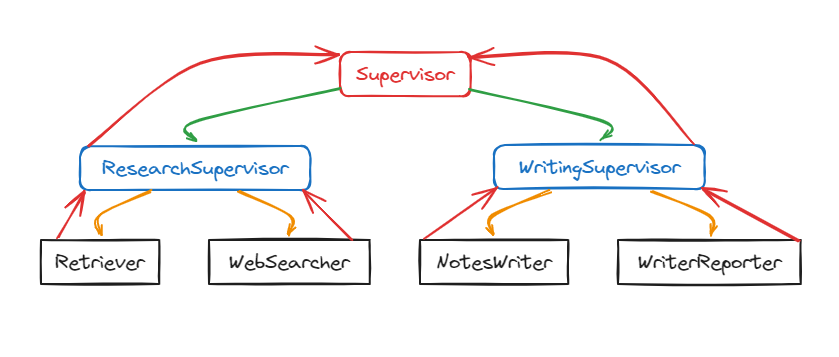